## 6.1 不同类型的微调

微调语言模型最常见的方法是```指令微调```和```分类微调```。指令微调通过在一组任务上使用特定指令训练模型，用以提升模型对自然语言提示中任务描述的理解和执行能力，如图 6.2 所示。

![Alt text](imgs/PixPin_2025-07-24_22-45-29.png)

在分类微调中，模型被训练用来识别特定的一组类别标签，比如“垃圾短信”和“非垃圾短信”。分类任务的应用不仅限于 LLM 和电子邮件过滤，还包括从图像中识别不同种类的植物、将新闻分类到体育、政治或科技等主题，以及在医学影像中区分良性和恶性肿瘤。

但有一个关键点需要注意，经过分类微调的模型**只能预测训练中遇到的类别**。例如，它可以判断某内容是‘垃圾短信’还是‘非垃圾短信’（如图 6.3 所示），但不能对输入文本提供其他方面的信息。

> [!NOTE]
> 选择合适的微调方式
> 
> 指令微调提升了模型基于用户指令进行理解和生成响应的能力。它适用于需要基于复杂用户指令处理多任务的模型，增强模型的灵活性和交互质量。而分类微调则适合需要将数据精确分类为预定义类别的任务，例如情感分析或垃圾短信检测。
> 
> 虽然指令微调用途更广泛，但需要更大的数据集和更多的计算资源，才能训练出能胜任多种任务的模型。相比之下，分类微调所需的数据和计算量更少，但用途局限于模型已训练的特定类别。

## 6.2 准备数据集

![Alt text](imgs/PixPin_2025-07-24_23-06-36.png)

为了提供一个直观实用的分类微调示例，我们将采用一个包含垃圾消息和非垃圾消息的文本消息数据集。

注意，这里讨论的是通过手机发送的短信，而不是电子邮件。不过，相同的步骤也适用于电子邮件分类，感兴趣的读者可以在附录 B 的参考部分找到邮件垃圾分类数据集的链接。

In [ ]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url,zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
    
    with urllib.request.urlopen(url) as response:          #A
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())
    with zipfile.ZipFile(zip_path, "r") as zip_ref:        #B
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)          #C
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

#A 下载数据集
#B 解压数据集
#C 为解压的数据集文件设置.csv文件扩展名


In [4]:
import pandas as pd
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df      #A

#A 在 Jupyter Notebook 中可以直接渲染数据，或者用 print(df) 命令显示数据内容

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [5]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


为了简化起见，同时也因为我们倾向于使用小数据集进行教学（这便于更快地微调 LLM），我们选择对数据集进行下采样，每个类别保留 747 个样本。

In [6]:
# Listing 6.2 Creating a balanced dataset
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0]                                 #A
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)      #B
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])              #C
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())


#A 统计垃圾短信的实例数量
#B 随机抽取正常邮件实例，使其数量与垃圾短信实例相同。
#C 将正常短信子集与垃圾短信合并


Label
ham     747
spam    747
Name: count, dtype: int64


In [7]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [8]:
balanced_df

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


我们还需创建一个random_split函数，将数据集划分为三部分：70%用于训练，10%用于验证，20%用于测试。这些比例是机器学习中用于训练、调整和评估模型的常见划分比例：

In [9]:
# Listing 6.3 Splitting the dataset
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)     #A

    train_end = int(len(df) * train_frac)                               #B
    validation_end = train_end + int(len(df) * validation_frac)

    train_df = df[:train_end]                                           #C
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)  #D


#A 将整个 DataFrame 随机打乱
#B 计算数据分割的索引
#C 分割 DataFrame
#D 测试集默认大小为 0.2（即剩余部分）

In [10]:
csv_path = "chapter06"
train_csv_path = Path(csv_path) / "train.csv"
validation_csv_path = Path(csv_path) / "validation.csv"
test_csv_path = Path(csv_path) / "test.csv"
if train_csv_path.exists() is False:
    train_df.to_csv(train_csv_path, index=None)
    print(f"training csv file is saved as {train_csv_path}")
else:
    print("the train file is exist")

if validation_csv_path.exists() is False:
    validation_df.to_csv(validation_csv_path, index=None)
    print(f"validation csv file is saved as {validation_csv_path}")
else:
    print("the validation file is exist")

if test_csv_path.exists() is False:
    test_df.to_csv(test_csv_path, index=None)
    print(f"test csv file is saved as {test_csv_path}")
else:
    print("the test file is exist")


#validation_df.to_csv("validation.csv", index=None)
#test_df.to_csv("test.csv", index=None)

the train file is exist
the validation file is exist
the test file is exist


接着，我们需要实例化数据加载器。但在此之前，我们首先需要实现一个 PyTorch Dataset，用于定义数据的加载和处理方式。

为此，我们定义了SpamDataset类，实现了图 6.6 中展示的概念。该类负责处理多个关键任务：它识别训练数据集中最长的序列，对文本消息进行编码，并确保通过填充 token 将其他序列补齐到与最长序列相同的长度。

In [11]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [12]:
# Listing 6.4 Setting up a Pytorch Dataset class
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        self.encoded_texts = [                                      #A
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length

            self.encoded_texts = [                                  #B
                encoded_text[:self.max_length] for encoded_text in self.encoded_texts
            ]

        self.encoded_texts = [                                      #C
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text)) for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


#A 对文本进行预分词
#B 若序列超过最大长度则进行截断
#C 将序列填充至最长序列长度

In [13]:
train_dataset = SpamDataset(
    csv_file="chapter06/train.csv",
    max_length=None,
    tokenizer=tokenizer
)
print(train_dataset.max_length)

120


代码输出了 120，表明最长的序列不超过 120 个 token，这也是文本消息的常见长度。值得注意的是，我们之前预训练的模型的上下文长度限制为 1,024 个 token，因此可以处理最长 1,024 个 token 的序列。如果数据集中包含更长的文本，可以在创建训练数据集时传入 max_length=1024 参数，以确保数据不会超出模型支持的输入（上下文）长度。

In [14]:
val_dataset = SpamDataset(
    csv_file="chapter06/validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="chapter06/test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
print(val_dataset.max_length)
print(test_dataset.max_length)

120
120


将以上的数据集作为输入，我们就可以实例化数据加载器（可以回顾第 2 章中的操作）。然而，在本例中，目标表示的是类别标签，而非文本中的下一个 token。例如，选择```批量大小为 8 ```时，每个批次包含 8 个长度为 120 的训练样本和相应的类别标签，如图 6.7 所示。

![Alt text](imgs/PixPin_2025-07-25_00-47-25.png)

In [15]:
# Listing 6.5 Creating PyTorch data loaders
from torch.utils.data import DataLoader

num_workers = 0                  #A
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

#A 此设置可确保与大多数计算机兼容

In [16]:
import torch

# 1) 批次数 & 数据条数
print(f"Dataset size       : {len(train_loader.dataset)} 样本")
print(f"Batch size         : {train_loader.batch_size}")
print(f"Number of batches  : {len(train_loader)}")

# 2) 取一个 batch 看形状
input_batch, target_batch = next(iter(train_loader))
print("\n--- Batch tensor shapes ---")
print(f"input_batch  : {input_batch.shape}  (dtype={input_batch.dtype})")
print(f"target_batch : {target_batch.shape} (dtype={target_batch.dtype})")

# 3) 查看前 1~2 行具体内容（按你的数据类型自由调整打印方式）
print("\n--- First sample preview ---")
print("input  :", input_batch[0])
print("target :", target_batch[0])


Dataset size       : 1045 样本
Batch size         : 8
Number of batches  : 130

--- Batch tensor shapes ---
input_batch  : torch.Size([8, 120])  (dtype=torch.int64)
target_batch : torch.Size([8]) (dtype=torch.int64)

--- First sample preview ---
input  : tensor([   56,    64,   655,  5149,   450,    83,   294,    83,  4519,   492,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50

In [17]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


## 6.4 使用预训练权重初始化模型

![Alt text](imgs/PixPin_2025-07-25_00-51-51.png)

In [33]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257, # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0, # Dropout rate
    "qkv_bias": True # Query-key-value bias
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)

In [47]:
# Copyright (c) Sebastian Raschka under Apache License 2.0 (see LICENSE.txt).
# Source for "Build a Large Language Model From Scratch"
#   - https://www.manning.com/books/build-a-large-language-model-from-scratch
# Code: https://github.com/rasbt/LLMs-from-scratch

import json
import numpy as np
import os
import urllib.request

# import requests
import tensorflow as tf
import tiktoken
import torch
from tqdm import tqdm

# Import from local files
from chapter05.previous_chapters import GPTModel


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)  # add batch dimension
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)  # remove batch dimension
    return tokenizer.decode(flat.tolist())


def download_and_load_gpt2(model_size, models_dir):
    # Validate model size
    allowed_sizes = ("124M", "355M", "774M", "1558M")
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size not in {allowed_sizes}")

    # Define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    filenames = [
        "checkpoint", "encoder.json", "hparams.json",
        "model.ckpt.data-00000-of-00001", "model.ckpt.index",
        "model.ckpt.meta", "vocab.bpe"
    ]

    # Download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        download_file(file_url, file_path)

    # Load settings and params
    tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
    settings = json.load(open(os.path.join(model_dir, "hparams.json")))
    params = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)

    return settings, params


"""
def download_file(url, destination):
    # Send a GET request to download the file in streaming mode
    response = requests.get(url, stream=True)

    # Get the total file size from headers, defaulting to 0 if not present
    file_size = int(response.headers.get("content-length", 0))

    # Check if file exists and has the same size
    if os.path.exists(destination):
        file_size_local = os.path.getsize(destination)
        if file_size == file_size_local:
            print(f"File already exists and is up-to-date: {destination}")
            return

    # Define the block size for reading the file
    block_size = 1024  # 1 Kilobyte

    # Initialize the progress bar with total file size
    progress_bar_description = url.split("/")[-1]  # Extract filename from URL
    with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
        # Open the destination file in binary write mode
        with open(destination, "wb") as file:
            # Iterate over the file data in chunks
            for chunk in response.iter_content(block_size):
                progress_bar.update(len(chunk))  # Update progress bar
                file.write(chunk)  # Write the chunk to the file
"""


def download_file(url, destination):
    # Send a GET request to download the file
    with urllib.request.urlopen(url) as response:
        # Get the total file size from headers, defaulting to 0 if not present
        file_size = int(response.headers.get("Content-Length", 0))

        # Check if file exists and has the same size
        if os.path.exists(destination):
            file_size_local = os.path.getsize(destination)
            if file_size == file_size_local:
                print(f"File already exists and is up-to-date: {destination}")
                return

        # Define the block size for reading the file
        block_size = 1024  # 1 Kilobyte

        # Initialize the progress bar with total file size
        progress_bar_description = os.path.basename(url)  # Extract filename from URL
        with tqdm(total=file_size, unit="iB", unit_scale=True, desc=progress_bar_description) as progress_bar:
            # Open the destination file in binary write mode
            with open(destination, "wb") as file:
                # Read the file in chunks and write to destination
                while True:
                    chunk = response.read(block_size)
                    if not chunk:
                        break
                    file.write(chunk)
                    progress_bar.update(len(chunk))  # Update progress bar


def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params


def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))


def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params["wte"])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx


def main(gpt_config, input_prompt, model_size):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

    gpt = GPTModel(gpt_config)
    load_weights_into_gpt(gpt, params)
    gpt.to(device)
    gpt.eval()

    tokenizer = tiktoken.get_encoding("gpt2")
    torch.manual_seed(123)

    token_ids = generate(
        model=gpt,
        idx=text_to_token_ids(input_prompt, tokenizer).to(device),
        max_new_tokens=25,
        context_size=gpt_config["context_length"],
        top_k=50,
        temperature=1.0
    )

    print("Output text:\n", token_ids_to_text(token_ids, tokenizer))


if __name__ == "__main__":

    torch.manual_seed(123)

    CHOOSE_MODEL = "gpt2-small (124M)"
    INPUT_PROMPT = "Every effort moves you"

    BASE_CONFIG = {
        "vocab_size": 50257,     # Vocabulary size
        "context_length": 1024,  # Context length
        "drop_rate": 0.0,        # Dropout rate
        "qkv_bias": True         # Query-key-value bias
    }

    model_configs = {
        "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
        "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
        "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
        "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
    }

    model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

    BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

    main(BASE_CONFIG, INPUT_PROMPT, model_size)


File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe
Output text:
 Every effort moves you toward the ultimate goal. It's important not to take shortcuts, but not to take shortcuts that only benefit those most at the


In [48]:
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [49]:
def generate_text_simple(model, idx, max_new_tokens, context_size): #A
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]                           #B
        with torch.no_grad():
           logits = model(idx_cond)

        logits = logits[:, -1, :]                                   #C
        probas = torch.softmax(logits, dim=-1)                      #D
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)       #E
        idx = torch.cat((idx, idx_next), dim=1)                     #F

    return idx


#A idx 是当前上下文中索引的数组，形状为 (batch, n_tokens)
#B 若上下文长度超出支持范围，则进行裁剪。例如，若模型仅支持 5 个 token，而上下文长度为 10，仅使用最后 5 个 token 作为上下文
#C 仅关注最后一个时间步，将形状从 (batch, n_token, vocab_size) 转换为 (batch, vocab_size)
#D probas 的形状为 (batch, vocab_size)
#E idx_next 的形状为 (batch, 1)
#F 将采样的索引追加到当前序列中，此时 idx 的形状为 (batch, n_tokens+1)

In [50]:
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [51]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


## 6.5 添加分类头

本节我们将修改预训练的模型，为分类任务的微调做准备。为此，我们需要替换原始输出层，原输出层将隐层表示映射到50,257个词汇的词汇表，而我们用一个较小的输出层将其映射到两个类别：0（‘非垃圾短信’）和1（‘垃圾短信’），如图6.9所示。

![Alt text](imgs/PixPin_2025-07-25_02-41-28.png)

In [52]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

> [!NOTE]
> 微调部分层与全部层的对比
> 
> 由于我们从预训练模型开始，并不需要对所有模型层进行微调。这是因为，在基于神经网络的语言模型中，低层通常捕捉到的是基本的语言结构和语义，这些特征适用于多种任务和数据集。因此，只微调最后几层（接近输出层），它们更专注于细致的语言模式和任务特定的特征，通常就足够使模型适应新任务。此外，微调较少的层在计算上也更加高效。对于有兴趣的读者，可以在附录B的参考部分找到更多关于微调哪些层的详细信息，包括相关实验。

In [53]:
for param in model.parameters():
    param.requires_grad = False

In [54]:
# Listing 6.7 Adding a classification layer
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)

请注意，在上述代码中我们使用了 BASE_CONFIG["emb_dim"]，在 gpt2-small (124M) 模型中它的值为 768，这样可以让后续代码更加通用，便于适配更大的 GPT-2 模型变体。

这个新的输出层 model.out_head 的 requires_grad 属性默认为 True，意味着它是模型训练过程中唯一会被更新的层。

从技术上讲，训练我们刚添加的输出层已经足够。然而，通过实验我发现，微调更多层能够显著提升微调后模型的预测性能

此外，我们还需将最后一个 Transformer 模块以及连接该模块和输出层的 LayerNorm 模块配置为可训练，如图6.10所示。

![Alt text](imgs/PixPin_2025-07-25_03-04-54.png)

In [56]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.trf_blocks[-1].parameters():
    if param.requires_grad == True:
        print("we have activated the last trf block as the trainable layer")
for param in model.final_norm.parameters():
    param.requires_grad = True
    print(param)

for param in model.final_norm.parameters():
    if param.requires_grad == True:
        print("we have activated the final LayerNorm as trainable layer")

we have activated the last trf block as the trainable layer
we have activated the last trf block as the trainable layer
we have activated the last trf block as the trainable layer
we have activated the last trf block as the trainable layer
we have activated the last trf block as the trainable layer
we have activated the last trf block as the trainable layer
we have activated the last trf block as the trainable layer
we have activated the last trf block as the trainable layer
we have activated the last trf block as the trainable layer
we have activated the last trf block as the trainable layer
we have activated the last trf block as the trainable layer
we have activated the last trf block as the trainable layer
we have activated the last trf block as the trainable layer
we have activated the last trf block as the trainable layer
we have activated the last trf block as the trainable layer
we have activated the last trf block as the trainable layer
Parameter containing:
tensor([1.3971e+00

尽管我们增加了一个新的输出层，并标记了某些层为可训练或不可训练，我们仍然可以像前几章那样使用这个模型。例如，我们可以像以前一样向模型输入一个示例文本。考虑以下示例文本：

In [57]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [58]:
with torch.no_grad():
    outputs = model(inputs)
    print("Outputs:\n", outputs)
    print("Outputs dimensions:", outputs.shape)  # shape: (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


在第 4 章和第 5 章中，相似的输入会生成形状为 [1, 4, 50257] 的输出张量，其中 50,257 表示词汇表大小。与前几章相同，输出张量的行数对应输入的 token 数量（在这里是 4 个）。不过，由于替换了模型的输出层，现在每个输出的嵌入维度（即列数）从 50,257 缩减为 2。

请注意，我们希望微调该模型，使其能够输出一个分类标签，用于判断输入是否为垃圾短信。为实现这一点，我们不需要微调所有 4 行输出，只需聚焦于单个输出 token。具体来说，我们将重点关注最后一行对应的输出 token，如图 6.11 所示。

![Alt text](imgs/PixPin_2025-07-25_03-12-36.png)

In [68]:
# To extract the last output token, illustrated in figure 6.11, from the output tensor, we use the following code:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


接下来，我们将重点讨论如何将这些值转换为类别标签预测。但在此之前，我们需要理解，为什么我们特别关注最后一个输出的token，而不是第一个、第二个或第三个输出token。

在第 3 章中，我们探讨了注意力机制，该机制在每个输入 token 与其他所有输入 token 之间建立关系。随后，我们引入了因果注意力掩码的概念，这在 GPT 类模型中被广泛使用。这种掩码限制每个 token 的关注范围，使其只能关注当前位置及之前的内容，从而确保每个 token 只能受到自身及前面 token 的影响，如图 6.12 所示。

![Alt text](imgs/PixPin_2025-07-25_03-32-32.png)



## 6.6 计算分类损失和准确率

本章到目前为止，我们已完成了数据集准备、预训练模型的加载，以及对模型进行分类微调的修改。在微调正式开始前，还剩下一小部分工作：实现微调过程中使用的模型评估函数（如图 6.13 所示）。我们将在本节完成这一部分

![Alt text](imgs/PixPin_2025-07-25_03-48-17.png)

在实现评估工具之前，我们先简单讨论一下如何将模型输出转换为类别标签预测。

在上一章中，我们通过 ```softmax``` 函数将 50,257 个输出转换为概率分布，然后通过 ```argmax``` 函数返回概率最高的位置，从而得到 LLM 生成的下一个 token 的 token ID。本章中，我们采用相同的方法来计算模型对于给定输入的预测结果是‘垃圾短信’还是‘正常短信’。唯一的区别是，这次的输出维度是 2，而不是 50,257 维。

In [69]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


为了计算分类准确率，我们对数据集中的所有样本进行 argmax 预测，并通过定义一个 calc_accuracy_loader 函数来计算预测正确的比例：

In [70]:
# Listing 6.8 Calculating the classification accuracy
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]                   #A
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

#A 最后一个输出 token 的 logits 值

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


可以看到，当前模型的预测准确率接近随机预测（在本例中为 50%）。为了提高预测准确率，我们需要对模型进行微调。

在微调模型之前，我们需要定义损失函数，以便在训练过程中对其进行优化。我们的目标是最大化模型的垃圾短信分类准确率，因此代码输出应为正确的类别标签：0 表示正常短信，1 表示垃圾短信。

然而，由于分类准确率不是一个可微分的函数，因此我们使用交叉熵损失作为替代来优化准确率。这里所说的交叉熵损失与第 5 章讨论的一致。

因此，calc_loss_batch 函数与第五章中的版本基本相同，唯一的调整是：我们只优化最后一个 token（model(input_batch)[:, -1, :]），而不是整个序列中的所有 token（model(input_batch)）：

In [72]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :] # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

我们使用 calc_loss_batch 函数来计算从前面定义的数据加载器获取的单个批次的损失。为了计算数据加载器中所有批次的损失，我们定义了 calc_loss_loader 函数，其功能与第五章中的描述相同。

In [73]:
# Listing 6.9 Calculating the classification loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:                                      #A
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

# Similar to calculating the training accuracy, we now compute the initial loss for each data set:
with torch.no_grad():                           #B
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)
    print(f"Training loss: {train_loss:.3f}")
    print(f"Validation loss: {val_loss:.3f}")
    print(f"Test loss: {test_loss:.3f}")


#A 确保批次数不超过数据加载器中的总批次数
#B 关闭梯度追踪以提高效率，因为当前未进行训练

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


> [!NOTE]
> 为什么train_loss 会飘动：
>
> | 随机来源                                         | 为什么会产生波动                                                                                                                                                                                                                | 典型症状                                                 |
> | -------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ---------------------------------------------------- |
> | **A. 采样随机性**<br/>(DataLoader `shuffle=True`) | `train_loader` 每次遍历都会 **重新洗牌**。<br/>函数只取 `num_batches=5`，于是每次评估都用到 **不同 5 个 batch**，自然平均损失不一样。                                                                                                                          | 在同一轮训练里反复 `calc_loss_loader(train_loader, …)`，数值仍上下跳 |
> | **B. 模型随机性**<br/>(Dropout / BatchNorm)       | 你在评估前用了 `torch.no_grad()`，但 **没把模型切到 `eval()`**：<br/>`python<br/>model.eval()          # 关闭 Dropout/BN 随机<br/>with torch.no_grad():<br/>    ...<br/>`<br/>- Dropout 会随机屏蔽神经元<br/>- BatchNorm 在 train 模式下用当前 batch 均值/方差 | 即便固定输入，也会因 Dropout 抽样不同而导致 loss 波动                   |




## 6.7 使用监督数据对模型进行微调

在本节中，我们定义并使用训练函数，对预训练的 LLM 进行微调，以提升其垃圾短信分类的准确率。训练循环的整体结构与第 5 章中的相同（详见图 6.15），唯一的区别在于，这里计算的是分类准确率，而不是通过生成文本来评估模型。

![Alt text](imgs/PixPin_2025-07-25_04-05-42.png)

In [74]:
# Listing 6.10 Finetuning the model to classify spam
def train_classifier_simple(model, train_loader, val_loader, optimizer, device,
num_epochs, eval_freq, eval_iter, tokenizer):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()                                      #A

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()                          #B
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()                                #C
            optimizer.step()                               #D
            examples_seen += input_batch.shape[0]          #E
            global_step += 1


            if global_step % eval_freq == 0:               #F
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        train_accuracy = calc_accuracy_loader(             #G
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen


#A 设置模型为训练模式
#B 重置上一批次的损失梯度
#C 计算损失梯度
#D 使用损失梯度更新模型权重
#E 更改逻辑：跟踪样本数量而非 token 数量
#F 可选评估步骤
#G 每个 epoch 后计算准确率

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [75]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 23.08 m

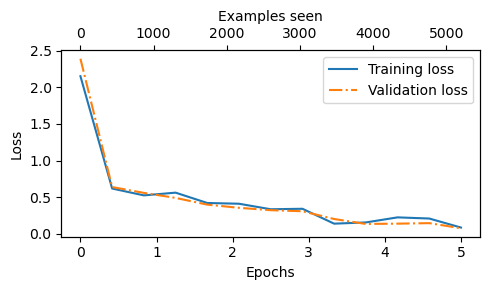

In [76]:
# Listing 6.11 Plotting the classification loss
import matplotlib.pyplot as plt
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_values, label=f"Training {label}")    #A
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()                                                 #B
    ax2.plot(examples_seen, train_values, alpha=0) # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()                                                #C
    plt.savefig(f"{label}-plot.pdf")
    plt.show()


#A 绘制训练轮次与训练和验证损失的变化图
#B 创建一个新的 x 轴，用于显示已处理样本数
#C 调整布局以留出空间

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

从图 6.16 中陡峭的下降曲线可以看出，模型在训练数据上的学习效果很好，且没有明显的过拟合迹象，训练集和验证集的损失值几乎没有差距。

> [!NOTE]
> 选择训练轮数
> 
> 在训练开始时，我们将 epoch 数量设置为 5。epoch 的具体数量取决于数据集和任务的难度，并没有通用的解决方案或推荐值。5 个 epoch 通常是一个合适的起点。如果在前几个 epoch 后模型出现过拟合迹象（如图 6.16 所示的损失曲线显示验证损失上升），我们可能需要减少 epoch 数量。相反，如果趋势线显示验证损失随着训练仍有下降空间，我们则应增加 epoch 数量。在本例中，5 个 epoch 是合理的选择，因为没有早期过拟合的迹象，且验证损失接近 0。

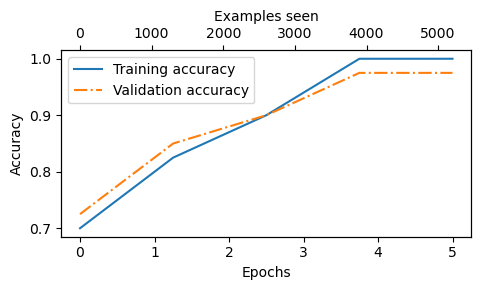

In [77]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

从图 6.17 的准确率曲线可以看出，模型在第 4 到 5 个训练周期后，训练和验证准确率均达到了较高水平。

需要注意的是，我们之前在使用 train_classifier_simple 函数时将 eval_iter 设置为 5，这意味着我们的训练和验证性能估计仅基于 5 个批次，目的是为了提高训练效率。

现在，我们将通过运行以下代码，计算整个数据集在训练集、验证集和测试集上的性能指标，这次不需要定义 eval_iter 值：

In [78]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


## 6.8 将 LLM 用于垃圾短信分类

In [79]:
# Listing 6.12 Using the model to classify new texts
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    input_ids = tokenizer.encode(text)                                   #A
    supported_context_length = model.pos_emb.weight.shape[1]

    input_ids = input_ids[:min(max_length, supported_context_length)]    #B

    input_ids += [pad_token_id] * (max_length - len(input_ids))          #C
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)   #D

    with torch.no_grad():                                                #E
        logits = model(input_tensor)[:, -1, :]                           #F
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"                #G


#A 准备模型输入
#B 截断过长序列
#C 填充序列至最长长度
#D 增加批次维度
#E 关闭梯度跟踪，进行模型推理
#F 获取最后一个输出 token 的 logits
#G 返回分类结果

In [80]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [81]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)
print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [82]:
torch.save(model.state_dict(), "review_classifier.pth")

In [ ]:
model_state_dict = torch.load("review_classifier.pth")
model.load_state_dict(model_state_dict)